## Section 1 - Imports

In [3]:
import pandas as pd # For Data Manipulation of Numerical Yables and Time Series 
import numpy as np # For Mathematical operations on arrays
import sklearn
import warnings
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split, GroupKFold, KFold # Split arrays or matrices into random train and test subsets, K-fold iterator variant with non-overlapping groups, K-fold iterator variant with non-overlapping groups.
from sklearn.metrics import mean_squared_error, mean_absolute_error # Mean absolute error regression loss.
from statistics import mean
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import normalize, PowerTransformer # Scale input vectors individually to unit norm (vector length).
#Potential ADDONS 
import lightgbm as lgb # For Distributed gradient boosting framework (XDBoost possible alternative)

## Section 2 - Data loading

In [4]:
train = pd.read_csv('train.csv') # Read a comma-separated values (csv) file into Train DataFrame
test = pd.read_csv('test.csv') # Read a comma-separated values (csv) file into Test DataFrame
submission = pd.read_csv('sample_submission.csv') # Read a comma-separated values (csv) file into Prediction DataFrame

In [5]:
display(train)
display(test)
display(submission)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0
...,...,...,...,...,...,...,...
4023995,4023996,125748,20,10,2.530117,4.971245,1
4023996,4023997,125748,20,10,2.563853,4.975709,1
4023997,4023998,125748,20,10,2.597475,4.979468,1
4023998,4023999,125748,20,10,2.631134,4.982648,1


,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
4023995,4023996,0
4023996,4023997,0
4023997,4023998,0
4023998,4023999,0


## Train Data

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [7]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [8]:
train.nunique().to_frame()

,0
id,6036000
breath_id,75450
R,3
C,3
time_step,3767571
u_in,4020300
u_out,2
pressure,950


In [9]:
train.R.value_counts().to_frame()

,R
50,2410080
5,1988800
20,1637120


In [10]:
train.time_step.max()

2.9372379779815674

In [11]:
train.query('u_out == 0').time_step.max()

0.999798059463501

## Test Data

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
dtypes: float64(2), int64(5)
memory usage: 214.9 MB


In [13]:
test.describe()

,id,breath_id,R,C,time_step,u_in,u_out
count,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06,4.024000e+06
mean,2.012000e+06,6.292796e+04,2.710785e+01,2.607038e+01,1.307083e+00,7.338098e+00,6.203864e-01
std,1.161629e+06,3.624924e+04,1.954281e+01,1.717103e+01,7.658902e-01,1.350955e+01,4.852908e-01
min,1.000000e+00,0.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.006001e+06,3.153050e+04,5.000000e+00,1.000000e+01,6.428454e-01,4.096735e-01,0.000000e+00
50%,2.012000e+06,6.305750e+04,2.000000e+01,2.000000e+01,1.308083e+00,4.377512e+00,1.000000e+00
75%,3.018000e+06,9.433325e+04,5.000000e+01,5.000000e+01,1.965240e+00,4.983472e+00,1.000000e+00
max,4.024000e+06,1.257480e+05,5.000000e+01,5.000000e+01,2.935203e+00,1.000000e+02,1.000000e+00


In [14]:
test.nunique().to_frame()

,0
id,4024000
breath_id,50300
R,3
C,3
time_step,2855528
u_in,2787822
u_out,2


In [15]:
test.C.value_counts().to_frame()

,C
10,1504800
50,1315840
20,1203360


## Submission Data

In [16]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 2 columns):
 #   Column    Dtype
---  ------    -----
 0   id        int64
 1   pressure  int64
dtypes: int64(2)
memory usage: 61.4 MB


In [17]:
submission.describe()

,id,pressure
count,4.024000e+06,4024000.0
mean,2.012000e+06,0.0
std,1.161629e+06,0.0
min,1.000000e+00,0.0
25%,1.006001e+06,0.0
50%,2.012000e+06,0.0
75%,3.018000e+06,0.0
max,4.024000e+06,0.0


## Data Summary 

All the breath id have same counts i.e. 80 <br>
Every breath id have unique timestamps. Every breath id contain 80 different timestamps

To determine the number of distinct values for each feature we can use the following<br>
To which we further find the following: <br>
 • 75,450 non-contiguous cycles in Training-Set<br>
 • 50,300 non-contiguous cycles in Test-Set<br>
 • Three different compliances(C) of [10,20,50] mL cm H2O<br>
 • Three different resitance(R) of[5,20,50] cm H2O/L/s<br>
 • Longest breath time is 3 seconds<br>
 • Valve has a 1 second delay before activating

### Data Validation 

In [18]:
train.isnull().sum(axis = 0).to_frame()


,0
id,0
breath_id,0
R,0
C,0
time_step,0
u_in,0
u_out,0
pressure,0


In [19]:
test.isnull().sum(axis = 0).to_frame()

,0
id,0
breath_id,0
R,0
C,0
time_step,0
u_in,0
u_out,0


### Breath Analysis

In [20]:
breath_one = train.query('breath_id == 1').reset_index(drop = True)
display(breath_one)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
75,76,1,20,50,2.553593,4.974474,1,6.399909
76,77,1,20,50,2.587754,4.978481,1,6.610815
77,78,1,20,50,2.621773,4.981847,1,6.329607
78,79,1,20,50,2.655746,4.984683,1,6.540513


In [21]:
breath_one.nunique().to_frame()

,0
id,80
breath_id,1
R,1
C,1
time_step,80
u_in,66
u_out,2
pressure,55


In [22]:
# Select all rows from the "train" DataFrame where the "breath_id" column is less than 5
df = train[train['breath_id'] < 5].reset_index(drop=True) 

In [23]:
display(df)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
315,316,4,50,50,2.400609,4.946119,1,7.032628
316,317,4,50,50,2.432266,4.954007,1,6.540513
317,318,4,50,50,2.464062,4.960767,1,6.399909
318,319,4,50,50,2.495845,4.966532,1,6.962326


In [24]:
# Define a function
def plot_sample(sample_id, df):
    # Select all rows from the DataFrame where the "breath_id" column matches the "sample_id" argument
    df_breath = df[df['breath_id'] == sample_id]
    # Extract the values of the "R" and "C" columns from the first row of the "df_breath" DataFrame
    r, c  = df_breath[['R', 'C']].values[0]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    # Create a new figure with a size of 12 inches wide and 4 inches tall.
    plt.figure(figsize=(12, 4))
    # For each column name in the "cols" list, plot the values of that column against the "time_step" column,
    for col in ['u_in', 'u_out', 'pressure']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    plt.legend()
    plt.title(f'Breath Sample {sample_id} - R={r}, C={c}')

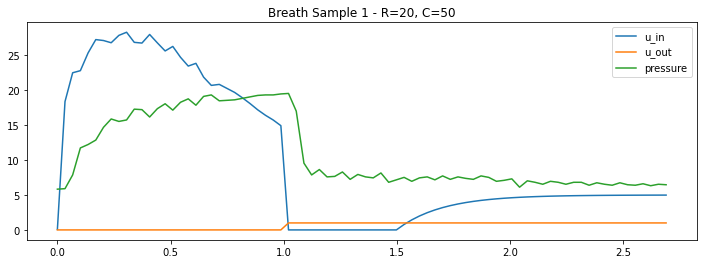

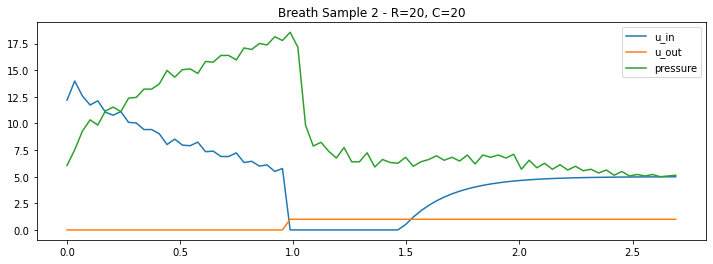

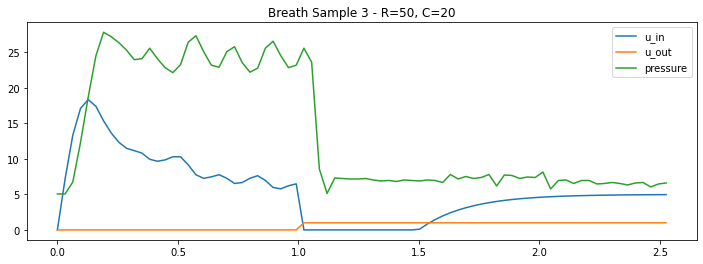

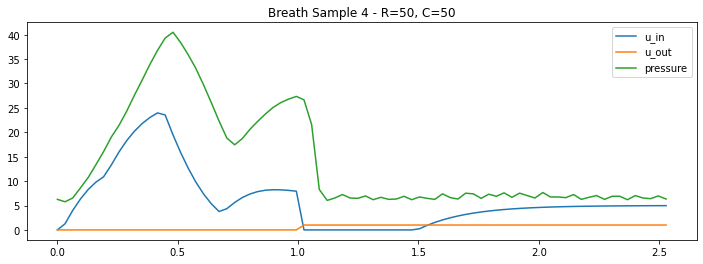

In [25]:
# Loop over all unique values in the 'breath_id' column of the DataFrame
# for each value, call the 'plot_sample' function with the value as the 'sample_id' argument,
for i in df['breath_id'].unique():
    plot_sample(i, train)

In [26]:
def add_features(df):
    # Moving average
    df["u_in_ma_lag1"] = df.groupby(["breath_id"])["u_in"].shift(1).rolling(window=3).mean()
    df["u_in_ma_lag-1"] = df.groupby(["breath_id"])["u_in"].shift(-1).rolling(window=3).mean()

    # Lag feature
    df["u_in_lag1"] = df.groupby(["breath_id"])["u_in"].shift(1)
    df["u_in_lag-1"] = df.groupby(["breath_id"])["u_in"].shift(-1)
    
    # u_in mean and std, u_out mean and std
    df["u_in_mean"] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df["u_in_std"] = df.groupby(['breath_id'])['u_in'].transform('std')
    df["u_out_mean"] = df.groupby(['breath_id'])['u_out'].transform('mean')
    df["u_out_std"] = df.groupby(['breath_id'])['u_out'].transform('std')
    
    return df.fillna(0)
    

In [27]:
train = add_features(train)
test = add_features(test)

In [28]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_ma_lag1,u_in_ma_lag-1,u_in_lag1,u_in_lag-1,u_in_mean,u_in_std,u_out_mean,u_out_std
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.000000,0.000000,18.383041,10.146007,10.12367,0.625,0.487177
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.000000,0.000000,0.083334,22.509278,10.146007,10.12367,0.625,0.487177
2,3,1,20,50,0.067514,22.509278,0,7.876254,0.000000,21.233714,18.383041,22.808822,10.146007,10.12367,0.625,0.487177
3,4,1,20,50,0.101542,22.808822,0,11.742872,13.658551,23.557983,22.509278,25.355850,10.146007,10.12367,0.625,0.487177
4,5,1,20,50,0.135756,25.355850,0,12.234987,21.233714,25.141513,22.808822,27.259866,10.146007,10.12367,0.625,0.487177


In [29]:
# LightGBM

folds = 4   # Number of folds for cross validation
kf = KFold(n_splits=folds) # Initializes a KFold object with the specified number of folds for cross-validation.

# Set LGBM hyper parameters
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}

# Set explanatory variable and objective variable
train_x = train.drop(["id", "breath_id", "pressure"], axis=1)
train_y = train["pressure"]

In [30]:
# Train model and predict

# Initialize empty lists to store the trained models and RMSE values for each fold
models = []
rmses = []
# Create an array of zeros with the length of the 'train_x' DataFrame to store the predicted values.
preds = np.zeros(len(train_x))

# Define the number of boosting rounds, early stopping rounds, and verbosity level for the LightGBM model.
num_boost_round = 20000
early_stopping_rounds = 1000
verbose_eval = 100

# Loop over the folds generated by the KFold object
for train_index, val_index in kf.split(train_x):
    # Split the training and validation data and labels according to the current fold indices.
    x_train = train_x.iloc[train_index]
    x_valid = train_x.iloc[val_index]
    y_train = train_y.iloc[train_index]
    y_valid = train_y.iloc[val_index]
    
    # Create LightGBM Datasets from the training and validation data and labels.
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
    
    # Train the LightGBM model on the training data and evaluate it on the validation data.
    model_lgb = lgb.train(lgbm_params,
                         lgb_train,
                         valid_sets=lgb_eval,
                         num_boost_round=num_boost_round,
                         early_stopping_rounds=early_stopping_rounds,
                         verbose_eval=verbose_eval)
    
    # Generate predictions on the validation data using the trained model, and calculate the RMSE.
    y_pred = model_lgb.predict(x_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    
    # Append the trained model and RMSE value to their respective lists
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    # Update the corresponding entries in the 'preds' array with the predicted values.
    preds[val_index] = y_pred

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2066
[LightGBM] [Info] Number of data points in the train set: 4527000, number of used features: 13
[LightGBM] [Info] Start training from score 11.214635
Training until validation scores don't improve for 1000 rounds
[100]	valid_0's l2: 2.22484
[200]	valid_0's l2: 1.73647
[300]	valid_0's l2: 1.50696
[400]	valid_0's l2: 1.36289
[500]	valid_0's l2: 1.27985
[600]	valid_0's l2: 1.19526


KeyboardInterrupt: 

In [31]:
# Calculate average of RMSE
mean(rmses)

StatisticsError: mean requires at least one data point

In [ ]:
# Create dataframe with actual target values and predicted target values
actual_pred_df = pd.DataFrame({
    "actual" : train_y,
    "pred" : preds
})

# Create line plot of the actual and predicted values over the range of the training data
actual_pred_df.plot(xlim=[0,320])